In [2]:
import os
import glob
import gdown
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchviz import make_dot
from pytorchyolo.models import load_model
from pytorchyolo.utils.transforms import Resize, DEFAULT_TRANSFORMS
from pytorchyolo.utils.utils import non_max_suppression

In [3]:
def download_weights():
    model_file=[
        'yolo_face_sthanhng.weights',
        'yolo_face_sthanhng.cfg'
    ]
    
    gdrive_url=[
        'https://drive.google.com/uc?id=1utquM5TAnfIa1Aq0X9fCvrllHiTWazdD',
        'https://drive.google.com/uc?id=1CPUZlYL5ik4d9y6oCyzi0930KgzawI6V'
    ]
    
    cwd=os.getcwd() 
    if 'weights' in os.listdir(cwd):
        for i in range(len(model_file)):
            if model_file[i] in os.listdir(os.path.join(cwd, 'weights')):
                print(model_file[i] + ':: status : file already exists')
            else:
                gdown.download(gdrive_url[i],os.path.join(cwd, 'weights', model_file[i]), quiet=False)
    else:
        os.makedirs(os.path.join(cwd,'weights'))
        for i in range(len(model_file)):
            gdown.download(gdrive_url[i], os.path.join(cwd, 'weights', model_file[i]), quiet=False)  

In [4]:
# download the necessary weights for YOLO-Face
download_weights()

yolo_face_sthanhng.weights:: status : file already exists
yolo_face_sthanhng.cfg:: status : file already exists


## YOLOFace with FGSM

In [15]:
# Patterned after FGSM tutorial (https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)
# Define what device we are using
print("CUDA Available: ", torch.cuda.is_available())
device, model = load_model('./weights/yolo_face_sthanhng.cfg', "./weights/yolo_face_sthanhng.weights")

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

epsilons = [.05]
use_cuda=True

CUDA Available:  False


In [16]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [17]:
FOLDER_PATH = os.path.join(os.getcwd(), 'images')
print(FOLDER_PATH)

def test( model, device, epsilon ):

    # Loop over all examples in test set
    for path in glob.glob(os.path.join(FOLDER_PATH, 'couple.jpg')):
        print(path)
#         print(torch.min(data), torch.max(data))
#         print('Input')
#         print(data.shape)
#         plt.imshow(np.transpose(data.squeeze(0).numpy(), (1, 2, 0)))
#         plt.show()
        
        data = cv2.imread(path)
        print(data.shape)
        data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
    
        data = transforms.Compose([DEFAULT_TRANSFORMS,Resize(416)])((data, np.zeros((1, 5))))[0].unsqueeze(0)
    
        data = data.to(device)
        
        print('Input')
        plt.imshow(np.transpose(data.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        plt.show()
        
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        
        # Forward pass the data through the model
        output = model(data)
#         print('Model Output')
#         print(output)
#         print(output.shape)
    
        
        nms, nms_output = non_max_suppression(output, 0.5, 0.5)
        print('NMS')
        print(nms)
        print(nms_output)
        
        for face_index, face_row in enumerate(nms_output[0]): #nms_output[0] because the code/model is designed to take in several images at a time from the dataloader but we are only loading the image one at a time
            print('Face ', face_index)
            print(face_row)

            # Calculate the loss
            #TODO: determine what should be the ground truth
            loss = F.binary_cross_entropy(face_row[5:], torch.tensor([0.]))
            
            #x1 y1 lower left
            #x2 y2 upper right
            x1 = int(np.floor((face_row[0] - face_row[2] / 2).detach().cpu().numpy()))
            y1 = int(np.floor((face_row[1] - face_row[3] / 2).detach().cpu().numpy()))
            x2 = int(np.ceil((face_row[0] + face_row[2] / 2).detach().cpu().numpy()))
            y2 = int(np.ceil((face_row[1] + face_row[3] / 2).detach().cpu().numpy()))
            
            print('Cropped')
            print(x1, y1, x2, y2)
            cropped_image = data[:, :, y1:y2, x1:x2] #get the first dimension, the channels, and crop it
            plt.imshow(np.transpose(cropped_image.squeeze().detach().cpu().numpy(), (1, 2, 0)))
            plt.show()
            
            #Resize
            input_cropped_image = np.transpose(cropped_image.squeeze().detach().cpu().numpy(), (1, 2, 0)) #reshape the image to (w/h, h/w, channel)

            print('Resized')
            cropped_resized_image = np.transpose(transforms.Compose([DEFAULT_TRANSFORMS,Resize(128)])((input_cropped_image, np.zeros((1, 5))))[0], (1, 2, 0))
            plt.imshow(cropped_resized_image)
            plt.show()
            
            # Zero all existing gradients
            model.zero_grad()
            
            # Calculate gradients of model in backward pass
            loss.backward(retain_graph = True) #TODO: check if this is correct
            
            print('Graph')
            make_dot(loss, params=dict(model.named_parameters())).render("couple" + str(face_index), format="png")
            
            # Collect datagrad
            data_grad = data.grad.data
            print('Gradient')
            print(data_grad.shape)      
            plt.imshow(np.transpose(np.clip(data_grad.squeeze(0).numpy(), 0, 1), (1, 2, 0)))
            plt.show()

            # Call FGSM Attack
            perturbed_data = fgsm_attack(data, epsilon, data_grad)

            print(torch.min(perturbed_data), torch.max(perturbed_data))
            plt.imshow(np.transpose(perturbed_data.squeeze().detach().cpu().numpy(), (1, 2, 0)))
            plt.show()

E:\Documents\GitHub\THS-ST1\images


Epsilon 0.05
E:\Documents\GitHub\THS-ST1\images\couple.jpg
(267, 400, 3)
Input


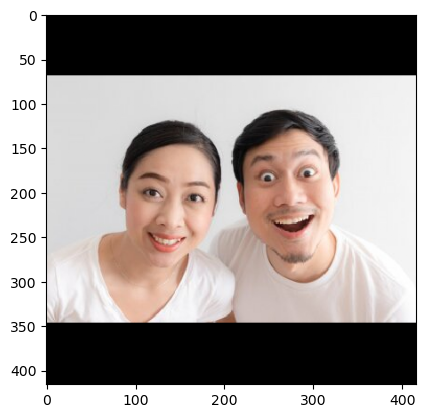

NMS
[tensor([[ 91.2910, 158.2145, 187.4069, 275.0190,   0.9991,   0.0000],
        [224.9028, 137.9499, 321.3420, 276.4984,   0.9975,   0.0000]])]
[tensor([[139.3489, 216.6168,  96.1159, 116.8045,   0.9997,   0.9994],
        [273.1224, 207.2242,  96.4393, 138.5485,   0.9981,   0.9994]],
       grad_fn=<IndexBackward0>)]
Face  0
tensor([139.3489, 216.6168,  96.1159, 116.8045,   0.9997,   0.9994],
       grad_fn=<UnbindBackward0>)
Cropped
91 158 188 276


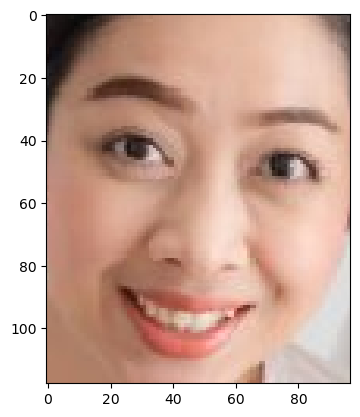

Resized


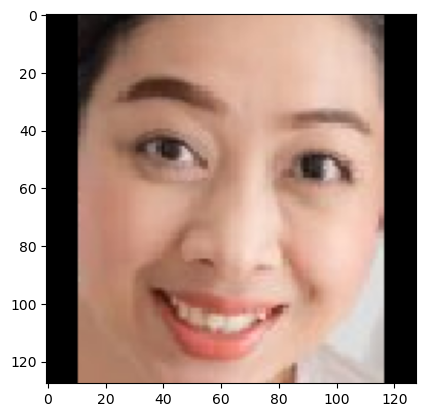

Graph
Gradient
torch.Size([1, 3, 416, 416])


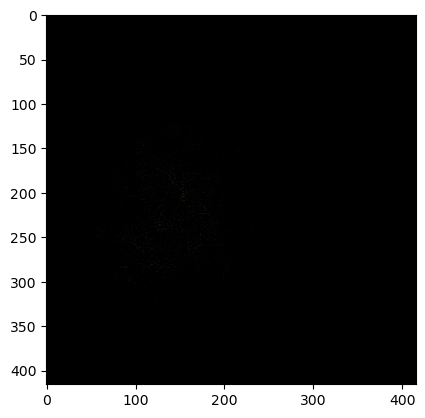

tensor(0., grad_fn=<MinBackward1>) tensor(1., grad_fn=<MaxBackward1>)


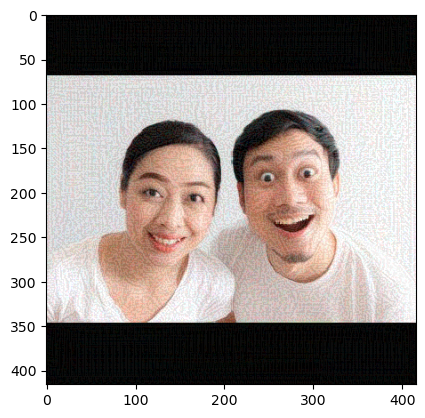

Face  1
tensor([273.1224, 207.2242,  96.4393, 138.5485,   0.9981,   0.9994],
       grad_fn=<UnbindBackward0>)
Cropped
224 137 322 277


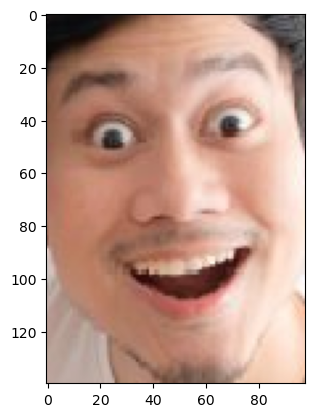

Resized


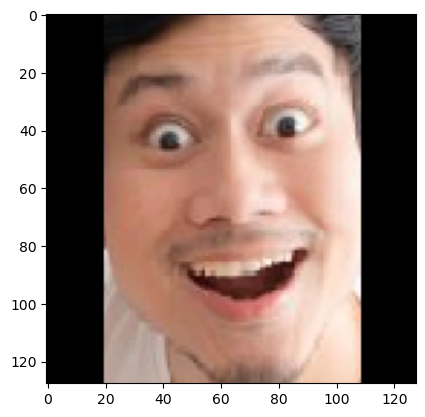

Graph
Gradient
torch.Size([1, 3, 416, 416])


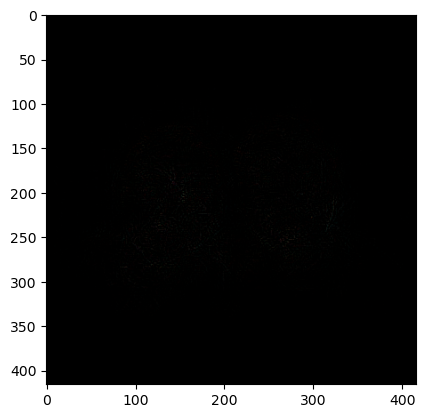

tensor(0., grad_fn=<MinBackward1>) tensor(1., grad_fn=<MaxBackward1>)


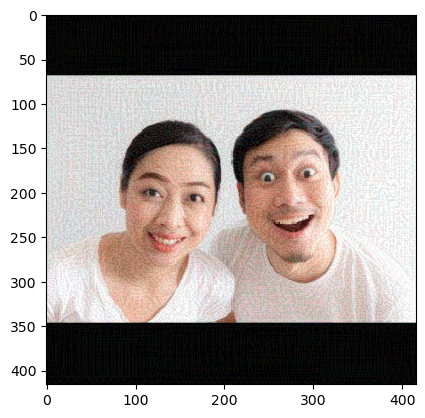

In [18]:
# loops for different epsilon
for eps in epsilons:
    print('Epsilon', eps)
    test(model, device, eps)

In [360]:
import torch

torch.manual_seed(0)

from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)

data = torch.rand(1, 3, 64, 64)
data.requires_grad = True

labels = torch.rand(1, 1000)

prediction = model(data)

In [361]:
model.zero_grad()

data.grad = None

loss = (prediction - labels).sum()

# grad_output = torch.autograd.grad(loss, data, torch.ones_like(loss), retain_graph = True)

loss.backward(retain_graph = True) # backward pass

model.zero_grad()

In [362]:
# make_dot(loss, params=dict(model.named_parameters())).render("test", format="png")

In [365]:
print(data.grad)

tensor([[[[-2.3018e-04,  4.9606e-04,  1.4967e-03,  ..., -5.8492e-05,
           -2.2334e-05,  2.2879e-04],
          [ 4.2426e-04,  7.6577e-04,  2.0240e-03,  ..., -5.4133e-04,
           -2.3797e-04,  3.6071e-04],
          [ 1.0454e-03,  9.8619e-04,  8.5518e-04,  ..., -4.4576e-04,
           -8.3747e-06,  5.2810e-04],
          ...,
          [ 2.9577e-04,  1.7165e-04,  1.1687e-04,  ...,  2.1008e-04,
            1.8377e-05,  1.2685e-05],
          [-6.1471e-05,  1.8556e-04,  2.9076e-04,  ...,  1.8885e-04,
           -4.1463e-05, -1.3619e-04],
          [-1.0184e-04, -5.2809e-06,  3.1096e-04,  ..., -1.2240e-04,
           -2.6508e-04, -4.9065e-05]],

         [[-3.2407e-04,  7.3732e-04,  1.5965e-03,  ..., -1.5133e-04,
            5.9317e-05,  3.9420e-04],
          [ 5.1769e-04,  1.0526e-03,  1.8715e-03,  ..., -6.8602e-04,
           -2.8005e-04,  5.3819e-04],
          [ 1.2599e-03,  8.6111e-04, -4.8245e-04,  ..., -5.6671e-04,
           -3.8765e-05,  7.2416e-04],
          ...,
     

In [357]:
print(torch.equal(prev, data.grad))

False
